## AMATH 581 Project
Manjaree Binjolkar

In [1]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import time
import sys
import os
import warnings

# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Other third-party packages
import netCDF4 as nc4

# Third-party packages for data interpolation
from scipy import interpolate
from scipy.interpolate import griddata
from xgcm import Grid
import xgcm.grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.dates as mdates


# del sys.modules['oceanliner_functions']  # uncomment if troubleshooting oceanliner_functions
# import oceanliner #uncomment if you don't have oceanline function in the same directory
from oceanliner_functions import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp, rotate_vector_to_EN

*Note: The code for oceanliner functions can be found here https://github.com/kdrushka/oceanliner
This python package is still being developed by Principal Oceanographer Kyla Drushka and me. I am using some of the functions here that I have manually copied for downloading the data, reshaping the data to get u and v velocities for all the days. 
The package can be installed using github.

### About the data:
The dataset used here is Pre-SWOT Level-4 Hourly MITgcm LLC4320 Native 1/48-degree GridPre-SWOT Level-4 numerical simulation datasets Version 1.0. It includes 15 regional subsets with an approximate 4x4-degree lat/lon box area..The simulation covers a period from 13 September 2011 to 14 November 2012. More information can be found here https://podaac.jpl.nasa.gov/announcements/2021-04-30-Pre-SWOT-L4-Hourly-MITgcm-LLC4320-Native-1/48-degree-Grid-Oceanographic-V1.0-Datasets-Release

### Motivation:
While working on developing the Oceanliner package in the summer, I had issues with calculating the vorticity using u and v velocity outputs from the data. The data for each day is 5 GB, for 30 days 150 GB and almost 3TB for 1 year. We decided to chunk for the output for every month but the vorticity computation takes too long for 30 days as well. In this project, I am hoping to reduce the computation time for calculating vorticity using sparse matrices as we did in the homework 3. We are using a different vorticity equation, but I am hoping to get positive results. In addition to this, I would like to understand the difference between the two vorticity equations. 

### Research Problem:
I am comparing the computational time it takes for 10 days (in the interest of time) for the both equations.


*Note: To get the data from earthdata website - first make sure you have an earthdata login, second run setupearthdatalogin function and the download function.

Specify the user input using the following the code:

In [2]:
# --------------------------------------------------------------------
# USER INPUTS: 
# --------------------------------------------------------------------
# *** users should only have to modify the variables in this cell ***
# --------------------------------------------------------------------


# ------------ region and time span

# RegionName: region with MITgcm llc4320 data on the PO.DAAC 
#   options are:
#     WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
#     MarmaraSea  LabradorSea  CapeBasin Boknis GotlandBasin NWAustralia WestAtlantic Yongala
RegionName = 'WesternMed'
#RegionName = 'ACC_SMST'


# start_date:  first date to subsample the model. 
#   MITgcm llc4320 data are from 2011-Sep-13 to 2012-Nov-15
start_date = datetime.date(2012,1,1)
# ndays: number of days over which to subsample the model (starting at start_date) 
#   note: ndays must be >1 
#   note: a large number of ndays may crash smaller machines
ndays = 10 
# --------------------------------------------------------------------


# ------------ directories -------------------------------------------

#ocean computer
datadir = '/home/manjaree/Documents/oceanliner_data/osse_model_input/'  # input model data are here
outputdir = '/home/manjaree/Documents/oceanliner_data/osse_output/'   # interpolated data stored here
figdir = '/home/manjaree/Documents/figures/' # store figures#datadir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_


# ------------ sampling parameters ------------------------------------

# PLATFORM: which instrument to sample with:
#   options are glider, uctd, mooring, wave_glider, saildrone, waypoints, or trajectory_file
PLATFORM = 'glider' 
# -----  if *only* PLATFORM is specified, reasonable defaults will be selected for the following parameters:

# WAYPOINTS:
#  specify either a list of lon,lat waypoints as {'x':[151, 153], 'y':[-55, -56]}
#    note: for a mooring, specify a single value for x and y
#    note: xwaypoints & ywaypoints must have the same size
#  or, a filename (string) of a netCDF file specifying the waypoints as {'waypoint_file':'filename.nc'} (EXAMPLE NEEDED)
#  or, None - in which case a simple pattern within the domain will be selected based on "PATTERN" (useful for testing/demo)
#  ** note, if the waypoints are outside of the domain, get_survey_track will raise an error (TODO: add warning earlier)
WAYPOINTS = None #{'x':[2, 2, 2.5, 2.5, 2, 2], 'y':[38, 39, 39, 38, 38, 39]}

# PATTERN: if WAYPOINTS=None, generate waypoints using this pattern:
#   options are back-forth (repeated back+forth betwen two waypoints) or lawnmower (radiator survey)
#   if waypoints are set, the value of PATTERN is irrelevant 
PATTERN = 'lawnmower' # back-forth or lawnmower 

# AT_END: what to do after the end of the list of waypoints is reached.
#   options are reverse (follow the track back to the start), repeat (go straight back to start and then repeat) or terminate (stop) 
AT_END = 'reverse'

# zrange: depth range of measurements as a 2-element list. 
#   * note, if depth values are negative (As in MITgcm), zrange should be negative
zrange = [-1, -500]

# z_res: vertical sampling resolution in m
z_res = 5

# zmooring: for PLATFORM=mooring, 
#   specify the depth of the instruments
#   (default x/y is the center of the domain)
zmooring = [-1, -10, -50, -500, -1000]
      
# hspeed: horizontal speed of the platform (in m/s) 
hspeed = 0.25

# vspeed: vertical speed of the platform through the water (in m/s)
#   for glider, this is the speed at which the glider dives
#   for uctd, this is the fall-rate of the instrument
#   for mooring, wave_glider and saildrone vspeed is irrelevant
vspeed = 0.1


# DERIVED_VARIABLES: whether or not to compute the "derived variables" - 'steric_height' and/or 'vorticity'
#  it takes significant memory and time to derive and save the stored variables, so None is recommended unless these
#  variables are needed
DERIVED_VARIABLES = None # {'steric_height', 'vorticity'} # or, None

# ------------ save flags ------- ------------------------------------

# SAVE_FIGURES: if True, save some basic figures
SAVE_FIGURES = False 

# SAVE_PRELIMINARY: if True, save preliminary along-track data. 
#  This takes more space but is faster and less prone to crashing than the gridding step
SAVE_PRELIMINARY = False 


In [3]:
# store the user-specified details in "sampling_details" variable
sampling_details = {
   'PLATFORM' : PLATFORM,
    'WAYPOINTS' : WAYPOINTS,
    'PATTERN' : PATTERN,
    'zrange' : zrange,  
    'z_res' : z_res,
    'hspeed' : hspeed,
    'vspeed' : vspeed,
    'AT_END' : AT_END,
    'zmooring' : zmooring,
    'DERIVED_VARIABLES' : DERIVED_VARIABLES,
    'SAVE_PRELIMINARY' : SAVE_PRELIMINARY,
    'start_date' : start_date,
    'ndays' : ndays
}

#### Download & load model data and derived fields
Uncomment the following to download the data (I have it saved on the ocean computer in datadir)

In [4]:
#download_llc4320_data(RegionName, datadir, start_date, ndays)

In [5]:
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]

target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)]

# open the dataset
ds = xr.open_mfdataset(target_files)

# XC, YC and Z are the same at all times, so select a single time
# (note, this breaks for a single file - always load >1 file)
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

### Transform vector quantities to the tracer grid and rotate if needed

Interpolate velocities (ocean currents and wind) to the tracer grid for consistency with tracers.

In [6]:
# first, interpolate U,V and oceTAUX, oceTAUY to the tracer grid
print('interpolating to tracer grid')

# xgcm.Grid interp raises a DeprecationWarning
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


# define grid
grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                     'Y':{'center': 'j', 'left': 'j_g'},
                     'T':{'center': 'time'},
                     'Z':{'center': 'k'}})    
U_c = grid.interp(ds.U, 'X', boundary='extend')
V_c = grid.interp(ds.V, 'Y', boundary='extend')
# do the same for TAUX and TAUY:
oceTAUX_c = grid.interp(ds.oceTAUX, 'X', boundary='extend')
oceTAUY_c = grid.interp(ds.oceTAUY, 'Y', boundary='extend')

interpolating to tracer grid


In [7]:
# replace the vector variables in ds 
print('replacing vectors with tracer-grid versions')
ds['U'] = U_c
ds['V'] = V_c
ds['oceTAUX'] = oceTAUX_c
ds['oceTAUY'] = oceTAUY_c

replacing vectors with tracer-grid versions


In [8]:
# drop a bunch of other vars we don't actually use in this project
ds = ds.drop_vars({'DXV','DYU', 'DXC','DXG', 'DYC','DYG', 'XC_bnds', 'YC_bnds', 'Zp1', 'Zu','Zl','Z_bnds', 'nb'})
ds

<xarray.Dataset>
Dimensions:   (j_g: 265, i: 192, i_g: 192, j: 265, k: 76, k_u: 76, k_l: 76,
               k_p1: 77, time: 240)
Coordinates:
  * j_g       (j_g) float32 0.0 1.0 2.0 3.0 4.0 ... 261.0 262.0 263.0 264.0
  * i         (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 0.0 1.0 2.0 3.0 4.0 ... 260.0 261.0 262.0 263.0 264.0
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 66 67 68 69 70 71 72 73 74 75
  * k_u       (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 66 67 68 69 70 71 72 73 74 75
  * k_l       (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 66 67 68 69 70 71 72 73 74 75
  * k_p1      (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 67 68 69 70 71 72 73 74 75 76
  * time      (time) datetime64[ns] 2012-01-01 ... 2012-01-10T23:00:00
Data variables: (12/21)
    XC        (time, j, i) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    YC        (time, j, i) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    Depth     (time, j, i) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    XG        (time, j_g, i_g) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    YG        (time, j_g, i_g) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    RAZ       (time, j_g, i_g) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    ...        ...
    oceTAUY   (time, j, i) float64 dask.array<chunksize=(24, 264, 192), meta=np.ndarray>
    Theta     (time, k, j, i) float64 dask.array<chunksize=(24, 76, 265, 192), meta=np.ndarray>
    Salt      (time, k, j, i) float64 dask.array<chunksize=(24, 76, 265, 192), meta=np.ndarray>
    U         (time, k, j, i) float32 dask.array<chunksize=(24, 76, 265, 191), meta=np.ndarray>
    V         (time, k, j, i) float64 dask.array<chunksize=(24, 76, 264, 192), meta=np.ndarray>
    W         (time, k_l, j, i) float64 dask.array<chunksize=(24, 76, 265, 192), meta=np.ndarray>
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-01-01 23:00:00
    time_coverage_start:             2012-01-01 00:00:00
    title:                           LLC4320 regional MEDITERRANEAN SEA
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

In [9]:
#Creating and plotting sampling track
survey_track, survey_indices, sampling_details = get_survey_track(ds, sampling_details)

# print:
sampling_details

no waypoints specified - using defaults
originally,  17208  points
limited to  17200 points: n_profiles= 86.0 ,  100 depths per profile,  200 depths per two-way


{'zrange': [-1, -500.0],
 'z_res': 5,
 'hspeed': 0.25,
 'vspeed': 0.1,
 'AT_END': 'reverse',
 'PATTERN': 'lawnmower',
 'SAVE_PRELIMINARY': False,
 'PLATFORM': 'glider',
 'WAYPOINTS': None,
 'zmooring': [-1, -10, -50, -500, -1000],
 'DERIVED_VARIABLES': None,
 'start_date': datetime.date(2012, 1, 1),
 'ndays': 10,
 'distance_total_km': 214.9875,
 'time_total_s': 859950.0}

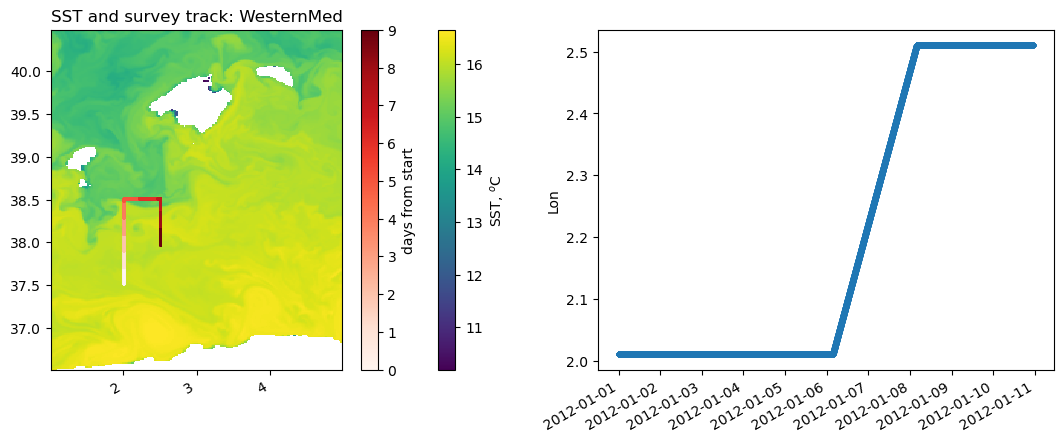

In [10]:
%matplotlib inline
plt.figure(figsize=(20,5))

# map of Theta at time zero
ax = plt.subplot(1,3,1)
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
if not (sampling_details['PLATFORM'] == 'mooring' or sampling_details['PLATFORM'] == 'sim_mooring'):
    tracko = plt.scatter(survey_track.lon, survey_track.lat, c=(survey_track.time-survey_track.time[0])/1e9/86400, cmap='Reds', s=0.75)
    plt.colorbar(ssto).set_label('SST, $^o$C')
    plt.colorbar(tracko).set_label('days from start')
    plt.title('SST and survey track: ' + RegionName)
else:
    plt.plot(survey_track.lon, survey_track.lat, marker='*', c='r')
    plt.title('SST and mooring location: ' + RegionName + ' region')


# lon/time plot
ax = plt.subplot(1,3,2)
iplot = slice(0,20000)
if not (sampling_details['PLATFORM'] == 'mooring'):
    plt.plot(survey_track.time.isel(points=iplot), survey_track.lon.isel(points=iplot), marker='.')
else:
    # not quite right but good enough for now.
    # (times shouldn't increase with depth)
    plt.scatter((np.tile(survey_track['time'].isel(time=iplot), int(survey_track['lon'].data.size))),
         np.tile(survey_track['lon'], int(survey_track['time'].isel(time=iplot).data.size)),marker='.')             
# plt.xlim([start_date + datetime.timedelta(days=0), start_date + datetime.timedelta(days=2)])
plt.ylabel('Lon')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()


plt.show()

### MAIN FUNCTION OF OCEANLINER:
Interpolate data with the specified sampling PATTERN to create `subsampled_data` then put on a regular grid and store in `sgridded`

In [12]:
%%time

# xarray raises a future version / depracation warning...
warnings.filterwarnings(action='ignore', category=FutureWarning)

subsampled_data, sgridded = survey_interp(ds, survey_track, survey_indices, sampling_details)
sgridded

Interpolating model fields to the sampling track...
Gridding the interpolated data...
  Theta
  Salt
  U
  V
CPU times: user 1min 1s, sys: 4.53 s, total: 1min 5s
Wall time: 57 s


<xarray.Dataset>
Dimensions:   (depth: 100, time: 172)
Coordinates:
  * depth     (depth) float64 -1.0 -6.0 -11.0 -16.0 ... -486.0 -491.0 -496.0
  * time      (time) datetime64[ns] 2012-01-01 ... 2012-01-10T21:29:10
Data variables: (12/15)
    Theta     (depth, time) float64 16.07 16.08 16.08 ... 13.23 13.24 13.24
    Salt      (depth, time) float64 37.1 37.12 37.12 37.12 ... 38.37 38.37 38.37
    U         (depth, time) float64 0.1182 0.08379 0.08343 ... -0.04389 -0.04387
    V         (depth, time) float64 0.02124 -0.026 ... -0.01678 -0.01676
    Eta       (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    KPPhbl    (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    ...        ...
    oceFWflx  (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceQnet   (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceQsw    (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceSflux  (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    lon       (time) float64 2.01 2.01 2.01 2.01 2.01 ... 2.51 2.51 2.51 2.51
    lat       (time) float64 37.51 37.52 37.53 37.54 ... 38.01 38.0 37.99 37.98

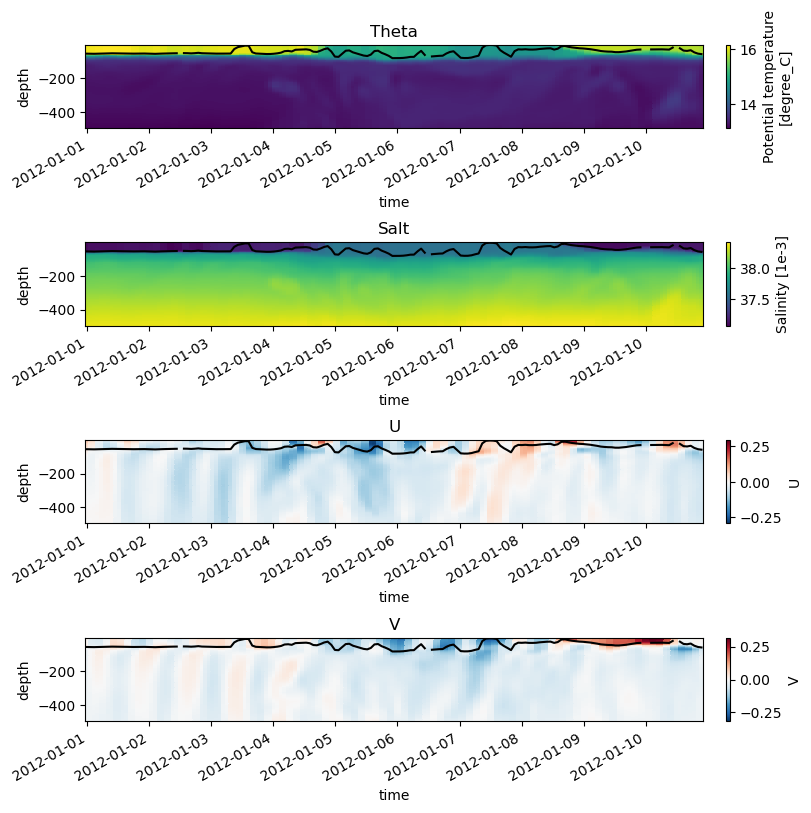

In [13]:
# Visualising 3d fields
vbls3d = ['Theta','Salt', 'U', 'V']       
if ((sampling_details['DERIVED_VARIABLES']) and ('vorticity' in sampling_details['DERIVED_VARIABLES'])):
    vbls3d.append('vorticity')
  
    

ylim = [min(sgridded['depth'].values), max(sgridded['depth'].values)]
# ylim = [-200, -1]

nr = len(vbls3d) # # of rows
fig,ax=plt.subplots(nr,figsize=(8,len(vbls3d)*2),constrained_layout=True)


for j in range(nr):
    sgridded[vbls3d[j]].plot(ax=ax[j], ylim=ylim)
    ax[j].plot(sgridded.time.data, -sgridded.KPPhbl.data, c='k')
    ax[j].set_title(vbls3d[j])

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_3D.png', dpi=400, transparent=False, facecolor='white')


### Calculating the vorticity for one day

In [17]:
#ds1 = target_files[0]
ds1 = xr.open_mfdataset(target_files[0])

# mean lat/lon of domain
xav = ds1.XC.isel(j=0).mean(dim='i')
yav = ds1.YC.isel(i=0).mean(dim='j')


# for transforming U and V, and for the vorticity calculation, build the xgcm grid:
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                            'Y':{'center': 'j', 'left': 'j_g'},
                            'T':{'center': 'time'},
                            'Z':{'center': 'k'}})

# calculating the vorticity
vorticity = (grid.diff(ds1.V*ds1.DXG, 'X') - grid.diff(ds1.U*ds1.DYG, 'Y'))/ds1.RAZ
vorticity = grid.interp(grid.interp(vorticity, 'X', boundary='extend'), 'Y', boundary='extend')
print(vorticity)

<xarray.DataArray 'mul-8fb4da0e227980c1069833ccb9d57641' (time: 24, k: 76,
                                                          j: 265, i: 192)>
dask.array<mul, shape=(24, 76, 265, 192), dtype=float64, chunksize=(24, 76, 263, 190), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 ... 2012-01-01T23:00:00
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 66 67 68 69 70 71 72 73 74 75
  * j        (j) float32 0.0 1.0 2.0 3.0 4.0 ... 260.0 261.0 262.0 263.0 264.0
  * i        (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0


*Note: I am calculating the vorticity here modfying the code for compute_derived_field function 

In [14]:
def compute_derived_fields_m(RegionName, datadir, start_date, ndays, DERIVED_VARIABLES):
    """ Check for derived files in {datadir}/derived and compute if the files don't exist


    Args:
        RegionName (str): It can be selected from the list of regions with pre-SWOT llc4320 data
        datadir (str): Directory where input model files are stored
        start_date (datetime): Starting date for computing derived fields
        ndays (int): Number of days from the start date to compute derived fields
        DERIVED_VARIABLES (str list): specifies which variables to derive (steric_height and/or vorticity)

    Returns:
        None
        
    Raises: 
        TBD: TBD

    """
    
    # directory to save derived data to - create if doesn't exist
    derivedir = datadir + 'derived/'
    if not(os.path.isdir(derivedir)):
        os.mkdir(derivedir)
        
    # files to load:
    date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
    target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
    
    # list of derived files:
    derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files

        
    # loop through input files, then do the following:
    # - compute steric height
    # - interpolate vector quantities (velocity and wind) to the tracer grid
    # - compute vorticity
    fis = range(len(target_files))
    
    cnt = 0 # count
    for fi in fis:
        # input filename:
        thisf=target_files[fi]
        # output filename:
        fnout = thisf.replace(RegionName + '_' , RegionName + '_derived-fields_')
        fnout = fnout.replace(RegionName + '/' , RegionName + '/derived/')
        # check if output file already exists
        if (not(os.path.isfile(fnout))):   
            print(f'computing {DERIVED_VARIABLES} for {thisf}') 
            # load file:
            ds = xr.open_dataset(thisf)
            # -------
            if 'vorticity' in DERIVED_VARIABLES:   
                # mean lat/lon of domain
                xav = ds.XC.isel(j=0).mean(dim='i')
                yav = ds.YC.isel(i=0).mean(dim='j')

                # for transforming U and V, and for the vorticity calculation, build the xgcm grid:
                # see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
                grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                                 'Y':{'center': 'j', 'left': 'j_g'},
                                 'T':{'center': 'time'},
                                 'Z':{'center': 'k'}})
                # --- COMPUTE VORTICITY using xgcm and interpolate to X, Y
                # see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
                vorticity = (grid.diff(ds.V*ds.DXG, 'X') - grid.diff(ds.U*ds.DYG, 'Y'))/ds.RAZ
                vorticity = grid.interp(grid.interp(vorticity, 'X', boundary='extend'), 'Y', boundary='extend')
                # make into dataset
                v_ds =vorticity.to_dataset(name='vorticity')
            
            # --- save derived fields in a new file
                    
            # if we only computed vorticity, dout = v_ds
            if 'vorticity' in DERIVED_VARIABLES:  
                dout = v_ds
                
                
            # if vorticity, add the attrs:
            if 'vorticity' in DERIVED_VARIABLES:  
                dout.vorticity.attrs = {'long_name' : 'Vertical component of the vorticity',
                                    'units' : 's-1',
                                    'comments_1' : 'computed on DXG,DYG then interpolated to X,Y'}         
               
            # - save netcdf file with derived fields
            netcdf_fill_value = nc4.default_fillvals['f4']
            dv_encoding = {}
            for dv in dout.data_vars:
                dv_encoding[dv]={'zlib':True,  # turns compression on\
                            'complevel':1,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                            'dtype':'float32',\
                            '_FillValue':netcdf_fill_value}
            # save to a new file
            print(' ... saving to ', fnout)
            # TROUBLESHOOTING::::: DELETE THE RETURN LINE
            #return dout, dv_encoding
            dout.to_netcdf(fnout,format='netcdf4',encoding=dv_encoding)


In [15]:
DERIVED_VARIABLES = {'vorticity'}

In [16]:
#Uncomment the following code to run and save the vorcity outputs
#compute_derived_fields_m(RegionName, datadir, start_date, ndays, DERIVED_VARIABLES)

computing {'vorticity'} for /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120101.nc
 ... saving to  /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_derived-fields_20120101.nc
computing {'vorticity'} for /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120102.nc
 ... saving to  /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_derived-fields_20120102.nc
computing {'vorticity'} for /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120103.nc
 ... saving to  /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_derived-fields_20120103.nc
computing {'vorticity'} for /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120104.nc
 ... saving to  /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_derived

In [ ]:
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]

target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)]

# open the dataset
ds = xr.open_mfdataset(target_files)

# XC, YC and Z are the same at all times, so select a single time
# (note, this breaks for a single file - always load >1 file)
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

In [ ]:
#ds_vorticity = define the derived dataset here

In [ ]:
# Visualising 3d fields including the vorticity this time
vbls3d = ['Theta','Salt', 'U', 'V']       
if ((sampling_details['DERIVED_VARIABLES']) and ('vorticity' in sampling_details['DERIVED_VARIABLES'])):
    vbls3d.append('vorticity')
  
    

ylim = [min(sgridded['depth'].values), max(sgridded['depth'].values)]
# ylim = [-200, -1]

nr = len(vbls3d) # # of rows
fig,ax=plt.subplots(nr,figsize=(8,len(vbls3d)*2),constrained_layout=True)


for j in range(nr):
    sgridded[vbls3d[j]].plot(ax=ax[j], ylim=ylim)
    ax[j].plot(sgridded.time.data, -sgridded.KPPhbl.data, c='k')
    ax[j].set_title(vbls3d[j])

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_3D.png', dpi=400, transparent=False, facecolor='white')


*Note: I have been unable to implement the following steps here, I was initially trying for 30 days but the computations were takig too long.

In [18]:
#Convert the u and v vectors to similar np.arrays as used in the homework problem
#Make the sparse matrices
#Use GE 
#Use LU
#Compare the two equations
#Conclusion
#future ideas